In [46]:
!nvidia-smi

Mon Jul 29 13:31:42 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

<h2> Import necessary Libraries</h2>

In [3]:
import os
import shutil
import zipfile
import platform
import warnings
from pathlib import Path
from dataclasses import dataclass

import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms

import lightning.pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor

from torchmetrics import MeanMetric
from torchmetrics.classification import MultilabelF1Score

from torchinfo import summary

In [48]:
# Sets the internal precision of float32 matrix multiplications.
torch.set_float32_matmul_precision('high')

# To enable determinism.
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

# Filter userwarnings.
warnings.filterwarnings(action="ignore", category=UserWarning)

<h2>Dataset and Base configuration</h2>

In [49]:
ROOT_PATH = Path('../datasets/')

<p>Declare all the hyperparameters used in this project</p>

In [50]:
@dataclass
class DatasetConfig:
    IMAGE_SIZE: tuple = (384, 384)
    CHANNELS: int = 3
    NUM_CLASSES: int = 10
    VALID_PCT: float = 0.1

    # Pre-defined MEAN & STD. DEV. of the ImageNet trained model.
    MEAN: tuple = (0.485, 0.456, 0.406)
    STD: tuple = (0.229, 0.224, 0.225)

    # Dataset file and folder paths.
    TRAIN_IMG_DIR: str = os.path.join(ROOT_PATH, 'train')
    TEST_IMG_DIR: str = os.path.join(ROOT_PATH, 'test')
    TRAIN_CSV_FILE: str = os.path.join(ROOT_PATH, 'train.csv')
    TEST_CSV_FILE: str = os.path.join(ROOT_PATH, 'sample_submission.csv')


@dataclass
class TrainingConfig:
    BATCH_SIZE: int = 32 # Reduce batch size incase of OOM error.
    NUM_EPOCHS: int = 10
    INIT_LR: float = 1e-3
    NUM_WORKERS: int = 0 if platform.system() == 'Windows' else os.cpu_count()
    OPTIMIZER_NAME: str = 'Adam'
    WEIGHT_DECAY: float = 1e-4
    USE_SCHEDULER: bool = True # Use LR scheduler or not.
    SCHEDULER: str = 'ReduceLROnPlateau' # Name of the scheduler to use.
    METRIC_THRESH: float = 0.4
    MODEL_NAME: str = 'efficientnet_v2_s'
    FREEZE_BACKBONE: bool = False

In [51]:
import json
import re

# Function to replace ObjectId and parse JSON
def parse_json_objects(content):
    # Replace MongoDB ObjectId with a string placeholder
    content = content.replace('ObjectId(', '').replace(')', '')
    
    # Split the content by closing braces followed by a new line
    pattern = re.compile(r'\{.*?\}', re.DOTALL)
    matches = pattern.findall(content)
    
    extracted_data = []
    # Parse each JSON object and extract imdbID and Genre
    for obj in matches:
        movie_data = json.loads(obj)
        imdb_id = movie_data.get('imdbID')
        genre = movie_data.get('Genre')
        title = movie_data.get('Title')
        year = movie_data.get('Released')
        # if imdb_id and genre and title:
        #     extracted_data = {'imdbID': imdb_id, 'Genre': genre, 'Title': title, 'Year': year}
        extracted_data.append({'imdbID': imdb_id, 'Genre': genre, 'Title': title, 'Year': year})
    return extracted_data

In [52]:
import chardet

def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        raw_data = f.read()
        result = chardet.detect(raw_data)
        return result['encoding']

In [53]:
processed_data = []
for i in os.listdir('../dataset/groundtruth'):
    # Read the file content
    file_path = '../dataset/groundtruth/' + i
    with open(file_path, 'r', encoding=detect_encoding(file_path)) as file:
        content = file.read()
    processed_data.extend(parse_json_objects(content))

df = pd.DataFrame(processed_data)

In [54]:
df

,imdbID,Genre,Title,Year
0,tt0095953,Drama,Rain Man,16 Dec 1988
1,tt0096438,"Animation, Comedy, Crime",Who Framed Roger Rabbit,22 Jun 1988
2,tt0094898,"Comedy, Romance",Coming to America,29 Jun 1988
3,tt0094737,"Comedy, Drama, Fantasy",Big,03 Jun 1988
4,tt0096320,Comedy,Twins,09 Dec 1988
...,...,...,...,...
8755,tt0090559,"Documentary, Sport",16 Days of Glory,07 Mar 1986
8756,tt0091173,Comedy,Hardbodies 2,12 Sep 1986
8757,tt0091213,"Action, Comedy, Crime",Hollywood Vice Squad,03 Jul 1986
8758,tt0092172,"Action, Horror, Sci-Fi",The Vindicator,14 Feb 1986


In [55]:
df['image_path'] =  '../dataset/images/' + df.imdbID + '.jpg'

In [67]:
df.to_csv('../dataset/metadata.csv', index=False)

In [66]:
df

,imdbID,Genre,Title,Year,image_path
0,tt0095953,Drama,Rain Man,16 Dec 1988,../dataset/images/tt0095953.jpg
1,tt0096438,"Animation, Comedy, Crime",Who Framed Roger Rabbit,22 Jun 1988,../dataset/images/tt0096438.jpg
2,tt0094898,"Comedy, Romance",Coming to America,29 Jun 1988,../dataset/images/tt0094898.jpg
3,tt0094737,"Comedy, Drama, Fantasy",Big,03 Jun 1988,../dataset/images/tt0094737.jpg
4,tt0096320,Comedy,Twins,09 Dec 1988,../dataset/images/tt0096320.jpg
...,...,...,...,...,...
8755,tt0090559,"Documentary, Sport",16 Days of Glory,07 Mar 1986,../dataset/images/tt0090559.jpg
8756,tt0091173,Comedy,Hardbodies 2,12 Sep 1986,../dataset/images/tt0091173.jpg
8757,tt0091213,"Action, Comedy, Crime",Hollywood Vice Squad,03 Jul 1986,../dataset/images/tt0091213.jpg
8758,tt0092172,"Action, Horror, Sci-Fi",The Vindicator,14 Feb 1986,../dataset/images/tt0092172.jpg


In [26]:
import os

In [27]:
temp = []
genre = []
image_names = os.listdir('../dataset/images')
for i in df['image_path'].values.tolist():
    if str(i.split('/')[-1]) not in image_names:
        temp.append(i)
        genre.append(df[df['image_path'] == i]['Genre'])

In [28]:
len(genre)

0

In [29]:
df.shape[0] - len(temp)

8064

In [30]:
len(temp)

0

In [31]:
df = df[~df['image_path'].isin(temp)]

In [32]:
classes = set()

for i in df['Genre'].values.tolist():
    if type(i) == str:  
        for j in i.split(','):
            classes.add(j.strip())

classes = list(classes)
classes

['War',
 'Biography',
 'Action',
 'Thriller',
 'Western',
 'Reality-TV',
 'Drama',
 'Short',
 'News',
 'Music',
 'Sport',
 'Comedy',
 'Fantasy',
 'Animation',
 'Sci-Fi',
 'History',
 'Romance',
 'Adventure',
 'Family',
 'Crime',
 'Musical',
 'Documentary',
 'Mystery',
 'Horror']

In [33]:
len(classes)

24

In [34]:
df.to_csv('../dataset/metadata.csv', index=False)

In [35]:
for i,j in pd.read_csv('../dataset/metadata.csv').iterrows():
    try:
        Image.open(j['image_path'])
    except:
        print(j['image_path'])

In [36]:
df = pd.read_csv('../dataset/metadata.csv')

In [41]:
import numpy as np
import matplotlib.pyplot as plt

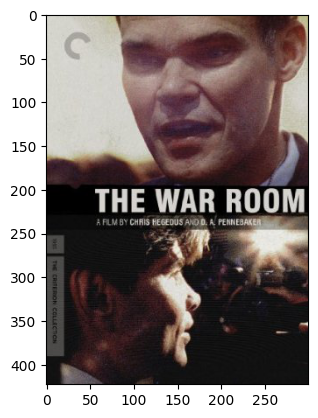

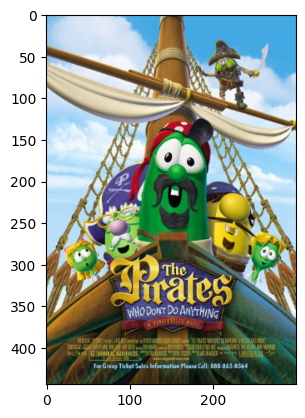

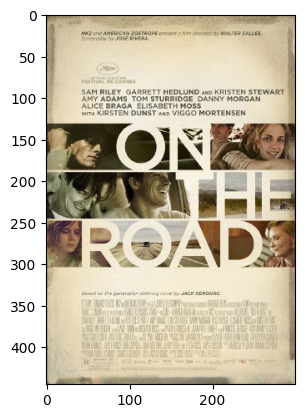

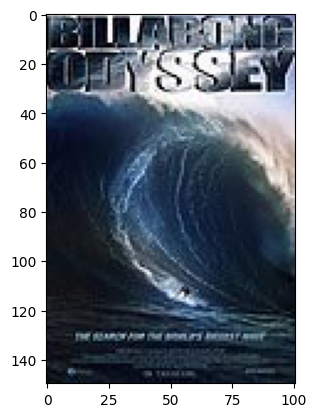

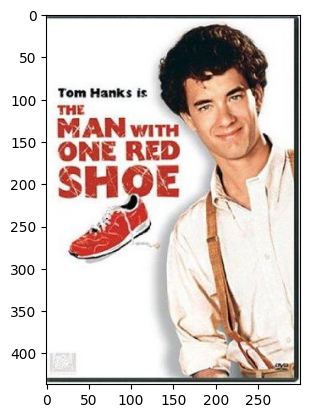

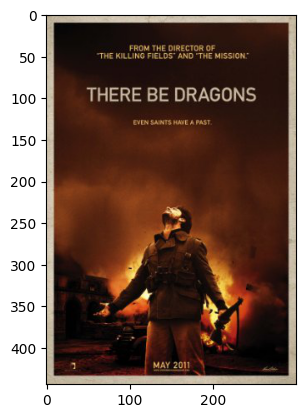

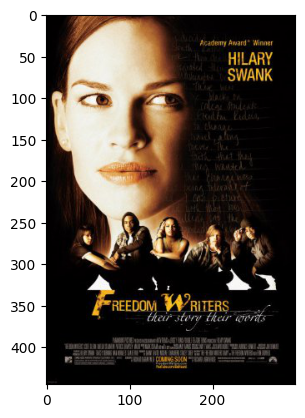

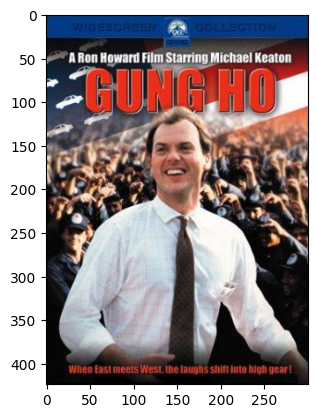

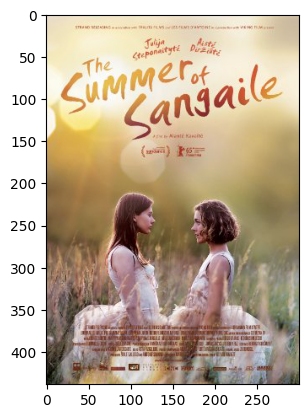

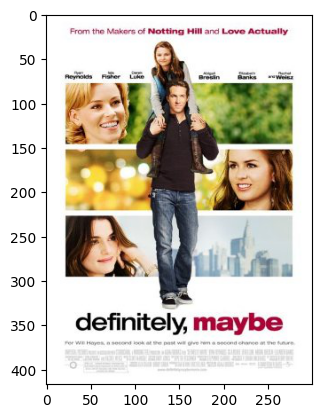

In [43]:
for i in range(10):
    random_num = np.random.randint(0, 8000)
    plt.imshow(Image.open(df['image_path'].values[random_num]))
    plt.show()
    plt.pause(0.5)

In [1]:
import pandas as pd

df = pd.read_csv('../dataset/metadata.csv')

In [2]:
df.head()

,imdbID,Genre,Title,Year,image_path
0,tt0095953,Drama,Rain Man,16 Dec 1988,../dataset/images/tt0095953.jpg
1,tt0096438,"Animation, Comedy, Crime",Who Framed Roger Rabbit,22 Jun 1988,../dataset/images/tt0096438.jpg
2,tt0094898,"Comedy, Romance",Coming to America,29 Jun 1988,../dataset/images/tt0094898.jpg
3,tt0094737,"Comedy, Drama, Fantasy",Big,03 Jun 1988,../dataset/images/tt0094737.jpg
4,tt0096320,Comedy,Twins,09 Dec 1988,../dataset/images/tt0096320.jpg


In [9]:
imgp = df['image_path'].values.tolist()

In [16]:
from PIL import Image

for i in range(len(df)):
    try:
        Image.open(df['image_path'].iloc[i])
        print(i)
    except:
        print(i, df['image_path'].iloc[i])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
1586
1587
1588
1589
1590
1591
1592
1593
1594
1595
1596
1597
1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700
1701
1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769


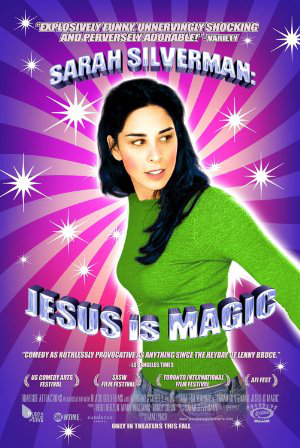

In [22]:
Image.open(df['image_path'].iloc[7777])